![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

This week, we'll be delving right into the projects. You and your group are going to build an AI tool that can help doctors tell if their patients have pneumonia. We'll start by understanding our problem, identifying:
* Who are our key stakeholders? (Radiologists AND Patients)
* What do they want to solve? (Detecting Pneumonia)
* What kind of data do they have? (X-ray images)

Once we have all of this information, we will take a step back and plan our approach to designing our medical imaging AI.


In [1]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)
    
def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)
  
def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data
  
class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of? 
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)
  
class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels      
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry. 
    history = history.history
    history.update({'epoch':list(range(len(history['val_acc'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_acc', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_acc', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'acc', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 1):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 1):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=1e-4, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])    
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16, 
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet', 
                                              include_top = False, 
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable
      
    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'], 
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters 

### defining project variables
# file variables
image_data_url       = 'https://drive.google.com/uc?id=1DNEiLAWguswhiLXGyVKsgHIRm1xZggt_'
metadata_url         = 'https://drive.google.com/uc?id=1MW3_FU6qc0qT_uG4bzxhtEHy4Jd6dCWb'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
gdown.download(image_data_url, './image_data.npy', True)
gdown.download(metadata_url, './metadata.csv', True)

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Milestone 1. Understanding medical imaging, pneumonia, and x-rays


**Discuss: Who are Radiologists? What is Pneuomonia?** 

## Exercise (Discussion)

If you have ever broken a bone, it is likely that you had an x-ray. 

![](http://www.seriousinjuryhelpline.co.uk/wp-content/uploads/2016/09/arm-break-320x320.jpg)

In [2]:
#@title What part of your body was this x-ray was taken on? What happened to this body part? { display-mode: "form" }
BodyPart= "Arm" #@param ["Leg","Lung","Heart","Arm","Fill Me In"]
WhatHappened = "Fracture" #@param ["Bruise","Fracture","Nothing","Fill Me In"]

if BodyPart == 'Arm':
  print('Yes! It is your arm. You can see your hand and your forearm.')
else:
  print('Not quite %s'%BodyPart)
  
if WhatHappened == "Fracture":
  print("One of your forearm bones broke. :( This is known as a fracture.")
else:
  print('Try again! Not quite %s'%WhatHappened)


Yes! It is your arm. You can see your hand and your forearm.
One of your forearm bones broke. :( This is known as a fracture.


## Exercise (Discussion)

So, how does an x-ray work and what kind of data does it give us? Let's learn about x-rays by watching the following video (click the image!)

[![How x-rays work](http://i3.ytimg.com/vi/gsV7SJDDCY4/hqdefault.jpg)](https://www.youtube.com/watch?v=gsV7SJDDCY4 "Everything Is AWESOME")


In [3]:
#@title Rank how well x-rays will pass through bone, fat, water, and air. { display-mode: "form" }

Best  = "Air" #@param ["Bone","Fat","Water","Air","Fill Me In"]
Second     = "Water" #@param ["Bone","Fat","Water","Air","Fill Me In"]
Third       ="Fat" #@param ["Bone","Fat","Water","Air","Fill Me In"]
Worst        ="Bone" #@param ["Bone","Fat","Water","Air","Fill Me In"]


if (Best == "Air") & (Second == "Water") & (Third == "Fat") & (Worst == "Bone"):
  print("Yes! X-rays don't pass very well through bone and pass the best through air. ") # embelish this explanation!!!
else:
  print('Try again! Think about how well each one passes through.')

# what is the major risk factor of using an x-ray?
### radiation
# why do we still use x-rays if we have this risk factor? 
### because it helps us!



Yes! X-rays don't pass very well through bone and pass the best through air. 


In [4]:
#@title What is the major risk factor of using an x-ray? { display-mode: "form" }

RiskFactor  = "Radiation" #@param ["Bruising", "Radiation", "Cost", "Time", "FillMe"]

if RiskFactor == 'Radiation':
  print("Yes! X-rays emit radiation that can be harmful to the body.")
if RiskFactor == "Cost":
  print("It may be costly to take one but cost is not a risk factor!")
if RiskFactor == "Time":
  print("It may take a while to get one but time is not a risk factor!")
if RiskFactor == "Bruising":
  print("Not quite! X-rays don't cause bruising.")

Yes! X-rays emit radiation that can be harmful to the body.


In [0]:
#@title If this risk exists, why do we still use x-rays? Discuss with your group. { display-mode: "form" }


# Milestone 2. Understand and visualizing our data


## Activity 2a. What data do we have?


### Exercise (Coding)

Our radiologist colleagues tell us: "We have x-ray images of healthy and sick patients." They give us a folder of data that looks like: 

```
data_folder/
  |-- PNEUMONIA/
      |--1.jpeg 
      |--2.jpeg            
      |--3.jpeg                        
      |--...
  |-- NORMAL/
      |--1.jpeg
      |--2.jpeg            
      |--3.jpeg                        
      |--...
```

As we see, we have two subfolders in our `data_folder` that store x-ray images in the `.jpeg` format. An image in the `PNEUMONIA` folder is of a patient who has pneuomonia while an image in the `NORMAL` folder is of a patient who is healthy. 

We will use our `get_metadata()` function to look at the classes as well as splits of our data.

In [7]:
# get a table with information about ALL of our images
metadata = get_metadata()

# what does it look like?
metadata.head()

,class,split,index
0,0.0,train,0
1,0.0,train,1
2,1.0,train,2
3,0.0,train,3
4,1.0,train,4


We see a few columns. What are they? 
1. `image_path`: This file path points to an individual image in our dataset. 
2. `class`: This is either PNEUMONIA (1) or HEALTHY (0). 
3. `split`: Our collaborators have provided us with two data sets: 
  * `training`: we will use this to teach our models
  * `test`: we will measure how well our models do on this set

We want to know how many PNEUMONIA and how many NORMAL images we have in total. We can count it with pandas or we can visualize it with seaborn's visualization tools. 

For pandas, you can try: 
```
data_source.groupby(['column_name']).count()
```

For visualizing in graphs, we will want to use the following: 

```
sns.countplot(x = 'column_name', data = data_source)
```

As a hint, try to identify:
* What is our column_name for PNEUMONIA or HEALTHY?
* What is our data table's name? 

       split  index
class              
0.0     1200   1200
1.0     1200   1200


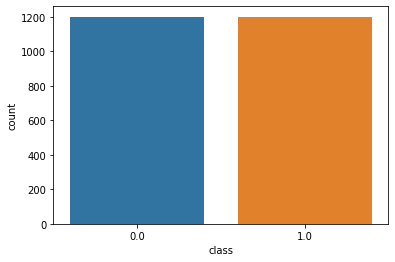

In [17]:
# grab our seaborn visualization toolbox!
import seaborn as sns
### YOUR CODE HERE
print (metadata.groupby(['class']).count())
sns.countplot(x = 'class', data = metadata)
### END CODE

We split our data into different 'sets' that each will work differently with our machine learning model. 

Think of our AI as a machine learning 'student'. 

**Training Set:** Our training set is like a training manual. Our algorithm will read, or 'train', on this over and over again to try and learn its task. 

**Test Set:** Our test set is like a test. It is testing our model on problems that it has not seen before. 

**We usually have a much larger training manual than our test. Let's see if this is the case with our data!**


Notice that our 'set' designation is found in the metadata. Plot the count of each 'set' in our data below:

       class  index
split              
test     400    400
train   2000   2000


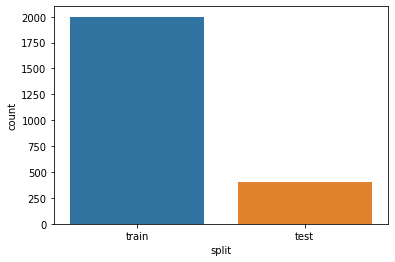

In [16]:
### YOUR CODE HERE
sns.countplot(x = 'split', data = metadata)
### END CODE

We are also interested in how many of each 'class' (PNEUMONIA or NORMAL) we have in each 'split' (train or test)
group by set and count the classes. Try this out with your group! As a hint... 
* you might visualize this with seaborn, setting another variable called 'hue' to be either 'class' or 'split'
* you may also try this with the pandas 'groupby' function along with 'count()'. You had done this earlier at the start of the week!

       class  index
split              
test     400    400
train   2000   2000


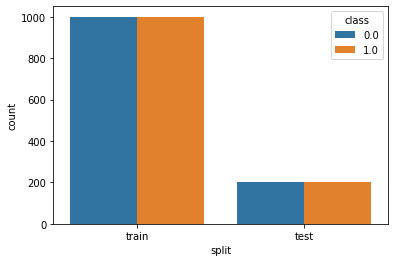

In [27]:
### YOUR CODE HERE
print (metadata.groupby(['split']).count())
sns.countplot(x = 'split', data = metadata, hue = 'class')

### END CODE

## Activity 2b. What does our data look like? 

We need to understand: what is our data even?? Is it numeric? Is it categorical? Is it a vector or a matrix??

**Question: What do you think the data is?** 

Discuss this with your group!



### Exercise (Coding)

We will check what we think the data is against what python tells us it is. 

We'll start by loading all of our training set using `get_train_data`. 


`get_train_data` is a function that **loads** all of our images and their labels. E.g.

```
train_data, train_labels = get_train_data()
```

`train_data` is a numpy array of our images, with size (2000, 64, 64, 3). 
`train_labels` is a numpy array of our images' labels, with size  (2000,)

We can grab a single `image` from `train_data`. 

**Let's try loading a single image!**

In [0]:
train_data, train_labels = get_train_data()
image = train_data[0,:]
image_label = train_labels[0]

**What kind of data do we have? What are its dimensions? What is its label?**

In [30]:
print('Our image is stored as %s in Python'%type(image))
print('Our image has dimensions of (%d, %d, %d)'%image.shape)
print('Our image has label %d'%image_label)

Our image is stored as <class 'numpy.ndarray'> in Python
Our image has dimensions of (64, 64, 3)
Our image has label 0


In [31]:
#@title What does image shape represent? { display-mode: "form" }

#@markdown What does the bold number (**64**, 64, 3) represent? 
Dimension_0  = "image height" #@param ["image width", "image height","number of colors","fill in"]

#@markdown What does the bold number (64, **64**, 3) represent? 
Dimension_1  = "image width" #@param ["image width", "image height","number of colors","fill in"]
  
#@markdown What does the bold number (64, 64, **3**) represent? 
Dimension_2  = "number of colors" #@param ["image width", "image height","number of colors","fill in"]

if Dimension_0 == 'image height':
  print("Yes! Dimension_0 is the height of the image.")
else:
  print("Try again for Dimension_0!")

if Dimension_1 == 'image width':
  print("Yes! Dimension_1 is the width of the image.")
else:
  print("Try again for Dimension_1!")
  
if Dimension_2 == 'number of colors':
  print("Yes! Dimension_2 stands for 3 colors - (r,g,b).")
else:
  print("Try again for Dimension_2!")


Yes! Dimension_0 is the height of the image.
Yes! Dimension_1 is the width of the image.
Yes! Dimension_2 stands for 3 colors - (r,g,b).


**Visualize single image with plot_one_image**

Remember our `plot_one_image` function from last week? We'll use that with our data to view our images! Let's see a single image. 

`plot_one_image` can take in either one image or many images. To use it with one image that is 3D, call:

```
plot_one_image(image)
```

To use it with many images, call:


```
plot_one_images(data, labels, index)
```

where:
* `data`: all of our images in one array
* `labels`: the labels corresponding to the images
* `index`: which image we want to see


Label: 


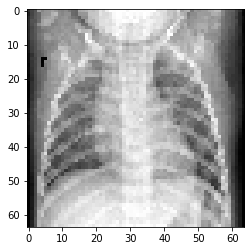

Label: 0.0


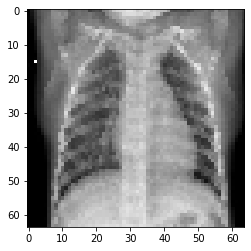

In [46]:
# plot a SINGLE image
### YOUR CODE HERE
plot_one_image(image)
plot_one_image(train_data, train_labels, 1)
### END CODE

### Exercise (Coding)     | Est Time | Within a student group

Let's visualize a few more images from our data! 

In [0]:
# use a for loop to visualize more images

### YOUR CODE HERE

### END CODE

We want to look at several PNEUMONIA and NORMAL images **separately**. Modify your for loop to visualize JUST PNEUMONIA and then JUST NORMAL images. 

In [0]:
# use a for loop to visualize PNEUMONIA images

### YOUR CODE HERE

### END CODE

In [0]:
# use a for loop to visualize NORMAL images

### YOUR CODE HERE

### END CODE

### Exercise (Discussion)

Now that we have our images, let's see if we can tell our images apart! Go see the instructor and gather the relevant handout for this! 

## Activity 2c. Fun with manipulating images

### Exercise (Coding)



Like we saw, an image is a 3D array with (y_location, x_location, rgb). Another way of saying this is that an image is a STACK of color matrices. Let's make this more tangible...

In [0]:
import numpy as np
x = np.random.rand(2,3,4)

In [48]:

x

array([[[0.03798426, 0.70321714, 0.66393626, 0.5924327 ],
        [0.99258281, 0.21028494, 0.32272068, 0.36663739],
        [0.22611204, 0.35592182, 0.85844379, 0.22513796]],

       [[0.4067045 , 0.76072488, 0.89686476, 0.88002617],
        [0.43650414, 0.18243527, 0.96681162, 0.50263897],
        [0.18062842, 0.67340874, 0.26793269, 0.85009038]]])

In [50]:

x[:,:,2]

array([[0.66393626, 0.32272068, 0.85844379],
       [0.89686476, 0.96681162, 0.26793269]])

In [0]:
# first copy our image... Make sure to copy it! Otherwise, we overwrite our original image. 
new_image = image.copy()

Now, we will change one of the color dimensions. 

In [52]:
new_image.shape

(64, 64, 3)

In [0]:
new_image[:,:,1] = 0

What did this do? Visualize it!!


Label: 


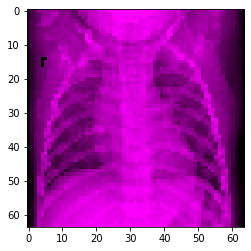

In [54]:
### YOUR CODE HERE
plot_one_image(new_image)
### END CODE

For this exericise, try to create a blue version of your image. 
Hint: Zero out the non-blue channels of the image. This is also known as tinting.

Label: 


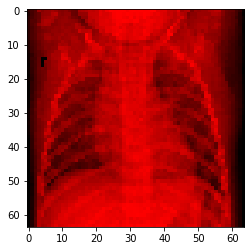

IndexError: ignored

In [67]:
### YOUR CODE HERE
plot_one_image(new_image)
new_image[:,:,3] = 0
### END CODE

### Exercise (Coding)

You've probably used an image crop before, where you segment part of an image out, like below. We will work on coloring a rectangle on your image.

![](https://ppom.nmediahosting.com/wp-content/uploads/2013/06/cropping.jpg)

The first step to doing this is identifying a rectangle in the image. Let's try to color a rectangle in our `new_image`. 

In [0]:
rect_image = image.copy()

Recall that you can access a pixel at the location (5, 5) in the image like...
```
image[5][5]
```

In [0]:
image[5][5]

To get the red color of this, you can do

In [0]:
image[5][5][0]

And you can change all of the color of one pixel with...
```
image[5][5] = (1, 1, 1)
```
or a single color (here, red) of that pixel:
```
image[5][5][0] = 0.5
```

With this in mind, can you write a for loop to draw a red rectangle on our image? 

In [0]:
### YOUR CODE HERE

### END CODE


# Milestone 3. Applying Machine Learning to Pneumonia Prediction



## Activity 3a. Defining our machine learning problem

Before we build our model, we have to identify what kind of problem it will solve and what data it's going to use. 

### Exercise (Discussion) 

What WILL our model look like? Remember, in machine learning, we always identify **inputs** and **outputs**. Our goal is to predict **outputs** from **inputs** with either **classification** or **regression**.

In **classification**, our output is a category (like dogs or cats). 

In **regression**, our output is a value (like 0, 0.1, 0.3, 100, ...). 

In [69]:
#@title How will our model operate? { display-mode: "form" }

#@markdown What are our inputs? 
inputs = "images" #@param ["pneumonia vs. normal", "images", "image edges", "probability of pneumonia vs. normal", "FillMe"]

#@markdown What are our outputs? 
outputs = "pneumonia vs. normal" #@param ["pneumonia vs. normal", "images", "image edges", "probability of pneumonia vs. normal", "FillMe"]

#@markdown What kind of problem will our AI model solve? 
problem_type  = "classification" #@param ["classification", "regression","FillMe"]


if inputs == "images":
  print("Yes, our inputs are our images!")
else:
  print('Not quite our inputs.')

if outputs == "pneumonia vs. normal":
  print("Yes, our outputs are pneumonia vs. normal!")
else:
  print('Not quite our outputs.')
  
if problem_type == "classification":
  print("We are trying to predict labels, therefore this is classification!")
else:
  print('Not quite our problem!')

Yes, our inputs are our images!
Yes, our outputs are pneumonia vs. normal!
We are trying to predict labels, therefore this is classification!


## Activity 3b. Building and evaluating models

### Exercise (Coding)


Now that you've built several machine learning models, build classifiers on our dataset and see how best you can do! The data is provided for you below. 

Sklearn takes in 'flat' data: that is, data that looks like a table, and is just samples by features. As we learned, our images are stored as a (64, 64, 3) array. To use our images with sklearn, we have to first flatten them, like we see below: 

In [0]:
(train_data, train_labels) = get_train_data(flatten = True);

We've tried a few models in sklearn since last week. Below, we list them with some sample parameters:
* `knn = KNeighborsClassifier(n_neighbors = 5)`
* `log = LogisticRegression()`
* `dt = DecisionTreeClassifier(max_depth = 2)`



Test your models with `accuracy_score` on the test_data, which can be grabbed through `get_test_data`!

For reference on these functions, see the Day 4 NN_ConsctientiousCars.ipynb notebook. 

**Try to build the best model that you can!** 

Vary the parameters of you code. 

In [0]:
### Here we load the train and test data for your to use.
(train_data, train_labels) = get_train_data(flatten = True)
(test_data, test_labels) = get_test_data(flatten = True)

### Use the models specified above to fit the function to your data
### E.g. knn = KNeighborsClassifier(n_neighbors = 5)
### Then follow the steps in Machine Learning! Fit, Predict, and Score

### YOUR CODE BELOW







### USE AS MANY CELLS AS YOU WANT!

# Fin!


![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)